# Seperating stock to forcast for certain dates depending on the product

In [13]:
%pip install nbformat


[notice] A new release of pip is available: 24.1.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
# import datasets and transformations (reusability purposes)
from IPython import get_ipython

get_ipython().run_line_magic('run', 'datasets.ipynb')

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3694211296.py:4: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Products [STOCK].txt', sep='\t', header=0) # stock
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3694211296.py:5: DtypeWarning: Columns (5,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [ITEMS].txt', sep='\t', header=0) # customer order items
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3694211296.py:6: DtypeWarning: Columns (43,57,104,139,210,244,251,289,293,310,321,324,326,344,348) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [MAIN].txt', sep='\t'

-------------- Product [STOCK] ----------------
   Adhesive  Alternate  Available  BackOrdered Box_Size  CaseQty Color  \
0       NaN        NaN          0            0      NaN      NaN   NaN   
1       NaN        NaN          0            0      NaN      NaN   NaN   
2       NaN        NaN          0            0      NaN      NaN   NaN   
3       NaN        NaN          0            0      NaN      NaN   NaN   
4       NaN        NaN          0            0      NaN      NaN   NaN   

   Commission   Cost  Currency_ExchangeRate  ...  SupplierName  SupplierNo  \
0           0   0.00                      0  ...           NaN         NaN   
1           0   0.00                      0  ...           NaN         NaN   
2           0   0.00                      0  ...           NaN         NaN   
3           0   0.00                      0  ...           NaN         NaN   
4           0  49.11                      0  ...           NaN         NaN   

  SupplierNotes SupplierPartNo Tag Tot

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3179924192.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3179924192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/3179924192.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

In [16]:
# create solution to add each first three unique values of the column 'ProductNumber' to a list
products_by_customer = set()

# loop through all product numbers
for index, row in product_sales.iterrows():
    product = row['ProductNumber']
    for i in range(len(product) - 2):
        customer_code = product[i:i+3]  # get the first three characters of the product number

        # add the customer code to the set
        products_by_customer.add(customer_code)

        # create a list for each customer code / if it exists, add it to the existing customer code list
        if f'custom_code_{customer_code}' in locals():
            locals()[f'custom_code_{customer_code}'].append(row.to_dict())
        else:
            locals()[f'custom_code_{customer_code}'] = [row.to_dict()]

print(f"All custom codes for existing products: \n{products_by_customer} \n ------------------------------------")

# Example to print one of the custom code lists
if 'custom_code_GOL' in locals():
    print(f"Records for custom code FRE: \n{locals()['custom_code_GOL']}")

All custom codes for existing products: 
{'HO-', 'SBC', '05W', 'XP-', '012', '628', '26-', '484', 'QU-', '148', '141', '98V', '637', 'RPB', '174', '199', '827', '27X', 'COR', '46V', 'PES', '206', '753', 'TFO', 'MEY', '070', '00U', 'GPB', '894', '14Y', '34S', '685', 'TR-', '93X', '752', 'CMI', '879', '39Y', '320', 'RB-', '558', '168', '932', 'YOM', '28Z', '718', 'LAC', '23T', 'GOR', '959', '422', '477', '781', '464', '535', '40Y', '899', 'V-0', 'CM-', '20T', '190', '950', 'OL-', 'OO-', 'ROY', '-F2', '803', 'HF-', '450', '08V', '59V', '338', '53X', 'REI', '54X', '438', '54W', '194', 'ORC', '79Z', '76Y', 'AF-', '370', '404', '938', '86X', '231', '89Y', '683', '732', '483', '309', 'MBP', 'US-', '757', '888', '673', '74W', '60Z', '492', '61V', '319', '31U', '60Y', '09T', '834', '668', '713', 'AZ-', 'F-T', '840', '245', '15S', '45R', '824', 'TW-', '342', 'CC-', '32X', '64W', '35Z', '64Z', '534', '-LB', '917', 'NF-', '16W', '68T', '00T', 'RC-', '508', '6Z-', '749', '445', '207', '937', '46Y',

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# convert custom_code_FRE to a DataFrame
custom_code_df = pd.DataFrame(custom_code_GOL)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = custom_code_df.copy()

features = ['ProductNumber', 'order_month', 'prev_month_sales', 'prev_week_sales',
            'moving_avg_3m', 'moving_avg_12m', 'moving_avg_18m',
            'var_12m', 'var_18m',
            'log_var_12m', 'log_var_18m',
            'yoy_growth', 'prev_2_month_sales', 'prev_3_month_sales',
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features)  # one-hot encode categorical features
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [20]:
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.append('../src')
from model_utils import find_best_hyperparameters, param_grids, evaluate_model
from model_utils import evaluate_sarima_model

In [21]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] 

In [22]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [23]:
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 14893.2312
Mean Squared Error (MSE): 1644616173.3435
Root Mean Squared Error (RMSE): 40553.8676
R-squared (R²): 0.8944
--------------------------------------------


In [ ]:
import pandas as pd

# handle potential column duplication during merge
product_sales = product_sales.drop(columns=['PhysicalInv'], errors='ignore')  # Drop the column if it exists
product_sales = pd.merge(product_sales, products_s[['ProductNumber', 'PhysicalInv']], on='ProductNumber')

# prepare sales data for SARIMAX model
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'])  # Convert 'OrderDate' to datetime format

# set index for time series modeling
sales_data = df.set_index(['OrderDate', 'ProductNumber'])
sales_data = sales_data['OrderQuantity']  # Focus on the 'OrderQuantity' column for the analysis

# resample the data to a monthly frequency and aggregate the order quantity
sales_data = sales_data.reset_index(level='ProductNumber')  # Reset the 'ProductNumber' index level
sales_data = sales_data.resample('M').sum()  # Aggregate by month ('M' for monthly)

# handle missing data (if any)
sales_data['OrderQuantity'].fillna(0, inplace=True)  # Fill missing order quantities with 0 (if any)

# split data into training and testing sets
train_size = int(len(sales_data) * 0.8)  # 80% for training, 20% for testing
train, test = sales_data.iloc[:train_size], sales_data.iloc[train_size:]

evaluate_sarima_model(sales_data, train, test)

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/1483290936.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_data = sales_data.resample('M').sum()  # Aggregate by month ('M' for monthly)
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_66390/1483290936.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data['OrderQuantity'].fillna(0, inplace=True)  # Fill missing order quantities with 0 (if any)
/Users/mwilko777/.pyenv/versions/3

Error for params (0, 0, 0, 1, 1, 0, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1233: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:

Error for params (0, 0, 0, 2, 1, 0, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1233: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:

Error for params (0, 1, 0, 1, 1, 0, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dat

Error for params (0, 1, 0, 2, 1, 0, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sta

Error for params (1, 0, 0, 0, 1, 0, 12): Input contains NaN.
Error for params (1, 0, 0, 0, 1, 1, 12): LU decomposition error.
Error for params (1, 0, 0, 0, 1, 2, 12): LU decomposition error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dat

Error for params (1, 0, 0, 1, 1, 0, 12): Schur decomposition solver error.
Error for params (1, 0, 0, 1, 1, 1, 12): Schur decomposition solver error.
Error for params (1, 0, 0, 1, 1, 2, 12): LU decomposition error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sta

Error for params (1, 0, 0, 2, 1, 0, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Error for params (1, 0, 0, 2, 1, 1, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Error for params (1, 0, 0, 2, 1, 2, 12): Schur decomposition solver error.


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sta

KeyboardInterrupt: 

In [ ]:
# NN imports
from sklearn.model_selection import GridSearchCV, cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

# NN METRICS ARE NOT ARENT BETTER THAN BASE MODELS, SO ITS COMMENTED OUT

# neural network model
def create_nn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# KerasRegressor
input_shape = X_train_scaled.shape[1]
nn_model = KerasRegressor(build_fn=create_nn_model, input_shape=input_shape, verbose=1)

grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grids(nn_model.__class__.__name__), cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

nn_params = grid_search.best_params_
print(f'Best Parameters: {nn_params}')

nn_model.set_params(**nn_params)

# print scores for each cross validation
scores = cross_val_score(nn_model, X_train_scaled, y_train, cv=5)
print(scores)

# train
history = nn_model.fit(X_train_scaled, y_train, epochs=nn_params['epochs'], batch_size=nn_params['batch_size'], validation_split=0.2, verbose=1)

y_pred_nn = nn_model.predict(X_val_scaled)

evaluate_model(nn_model, X_train_scaled, y_train)

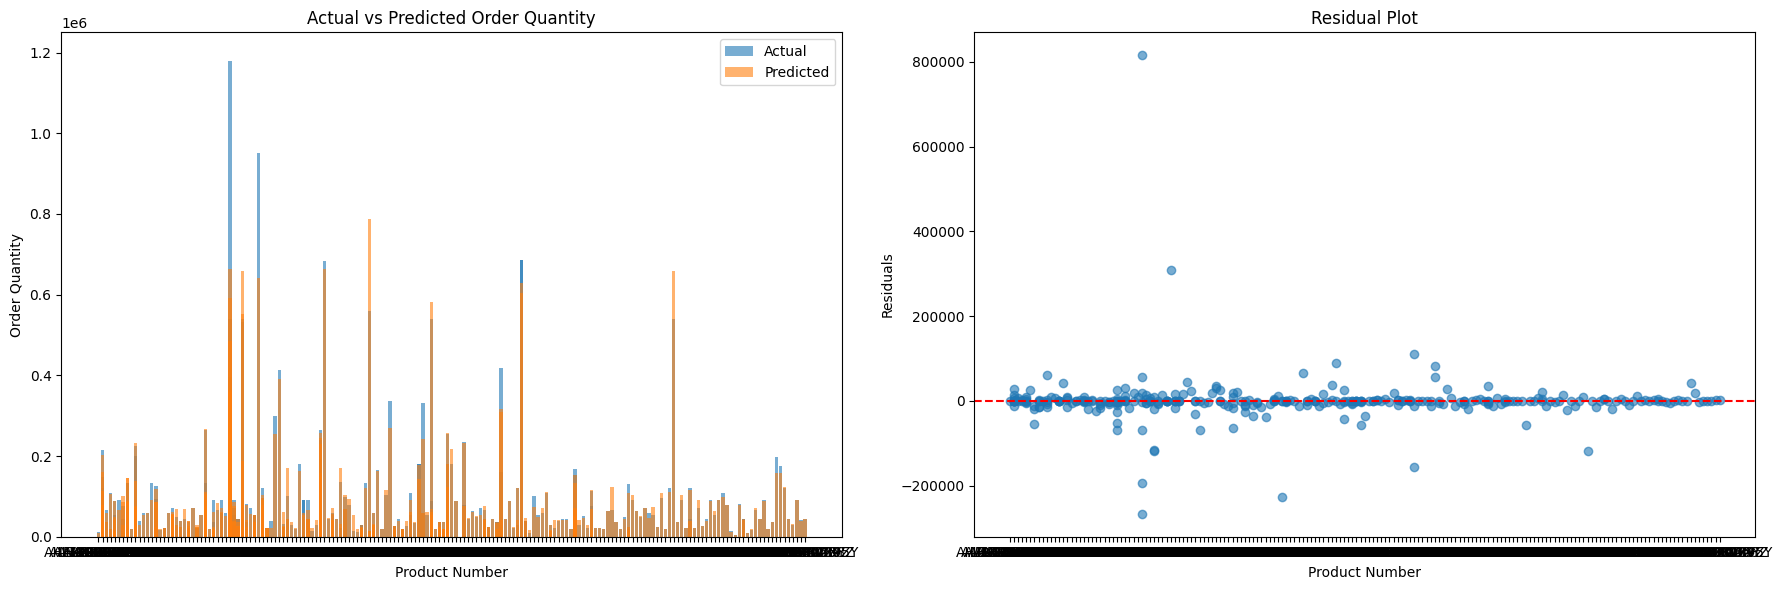

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# bar plot, actual and predicted values
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title('Actual vs Predicted Order Quantity')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# residual plot
residuals = y_val - y_pred_rf
axes[1].scatter(product_sales.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

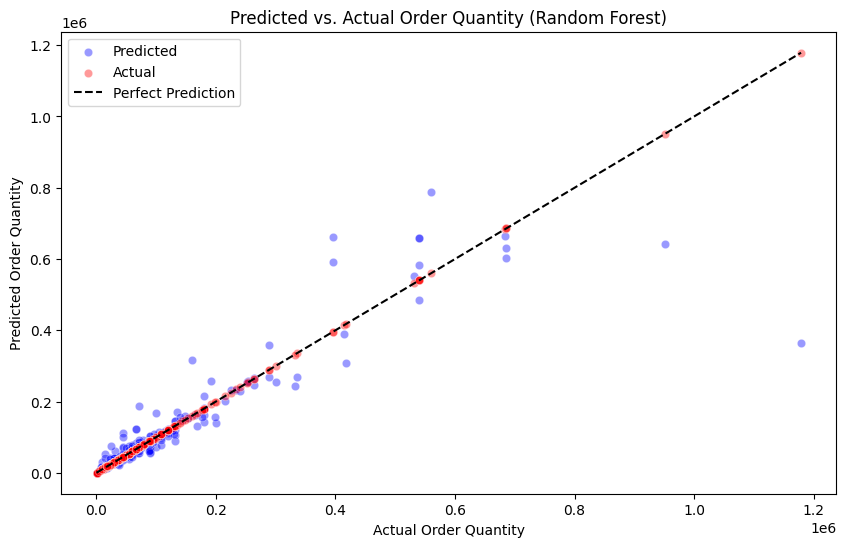

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='red', label='Actual')  

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title("Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()